In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import operator
import seaborn as sns
from scipy.stats import ttest_1samp, ttest_ind
from collections import Counter, defaultdict
import math
import sys
sys.path.append('..')
from helpers.funcs import *
import warnings; warnings.simplefilter('ignore')

In [2]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
cluster_names = {v:k for k, v in config['CLUSTER_NAMES'].items()}

In [3]:
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))

In [4]:
def split_party(part_tweets):
    return part_tweets[part_tweets['dem_follows'] > part_tweets['rep_follows']], part_tweets[part_tweets['dem_follows'] < part_tweets['rep_follows']]

In [5]:
def get_odds(tweets,  search):
    total = len(tweets)
    contains = tweets['text'].str.contains(search, regex=True, case=False).sum()
    return (contains + 1) / ((total - contains) + 1)

In [6]:
regexes = {
    'MUST': r"(\bmust(n['‘’`]?t?)?\b)|(\bmust['‘’`]?ve\b)",
    'SHOULD': r"(\bshould(n['‘’`]?t?)?\b)|(\bshould['‘’`]?ve\b)",
    'NEED TO': r"(\bneed to\b)|(\bneeds to\b)",
    'HAVE TO': r"(\bhave to\b)|(\bhas to\b)",
}

In [7]:
modal_list = []
log_odds_list = []
race = []

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR +event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'remove', 'isRT'])
    # data['text'].str.contains(r'http|\.com|www', case=False)
    data = filter_retweets(data)
    # get partisan tweets
    data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
    dem, rep = split_party(data)
    for k, v in regexes.items():
        modal_list.append(k)
        log_odds_list.append(np.log(get_odds(rep, v) / get_odds(dem, v)))
        race.append(shooter_race[event])

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


In [9]:
df = pd.DataFrame.from_dict({'modal':modal_list, 'log_odds':log_odds_list, 'race':race})

In [11]:
for i, g in df.groupby('modal'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

HAVE TO
Ttest_1sampResult(statistic=-6.608889419465189, pvalue=1.9483181505360368e-06)
MUST
Ttest_1sampResult(statistic=-4.462483429560479, pvalue=0.0002387595820821402)
NEED TO
Ttest_1sampResult(statistic=-3.033095955178946, pvalue=0.0065672893980417086)
SHOULD
Ttest_1sampResult(statistic=-3.0857102839532162, pvalue=0.005830693830236227)


In [12]:
for i, g in df.groupby('modal'):
    print(i)
    print(ttest_ind(np.array(g.log_odds[:9]), np.array(g.log_odds[9:])))

HAVE TO
Ttest_indResult(statistic=-0.7172876280818902, pvalue=0.4819227185015835)
MUST
Ttest_indResult(statistic=0.4785140142939136, pvalue=0.6377445818379925)
NEED TO
Ttest_indResult(statistic=-0.8677768687363027, pvalue=0.39634479253431565)
SHOULD
Ttest_indResult(statistic=1.6516513310829086, pvalue=0.11503690924059524)


In [14]:
for i, g in df.groupby('modal'):
    print(i)
    print(np.mean(np.array(g[g['race']=='white'].log_odds)))
    print(np.mean(np.array(g[g['race']=='POC'].log_odds)))
    print(ttest_ind(np.array(g[g['race']=='white'].log_odds), np.array(g[g['race']=='POC'].log_odds)))

HAVE TO
-0.4693199862542427
-0.2934380446273865
Ttest_indResult(statistic=-1.5585228589745972, pvalue=0.13561062140526003)
MUST
-0.279426861951316
-0.32271796519546864
Ttest_indResult(statistic=0.31423760779010695, pvalue=0.7567648797622604)
NEED TO
-0.1495078887393656
-0.20879674203541237
Ttest_indResult(statistic=0.49567984707856083, pvalue=0.625804914721529)
SHOULD
-0.30436008739638987
-0.04267669615802142
Ttest_indResult(statistic=-2.5279065325489634, pvalue=0.02049621218814681)


In [15]:
df.groupby('modal').median().sort_values('log_odds')

,log_odds
modal,
HAVE TO,-0.392316
MUST,-0.218644
SHOULD,-0.157624
NEED TO,-0.128364


In [16]:
df.groupby('modal').mean().sort_values('log_odds')

,log_odds
modal,
HAVE TO,-0.385567
MUST,-0.300042
SHOULD,-0.179749
NEED TO,-0.177741


[None, None]

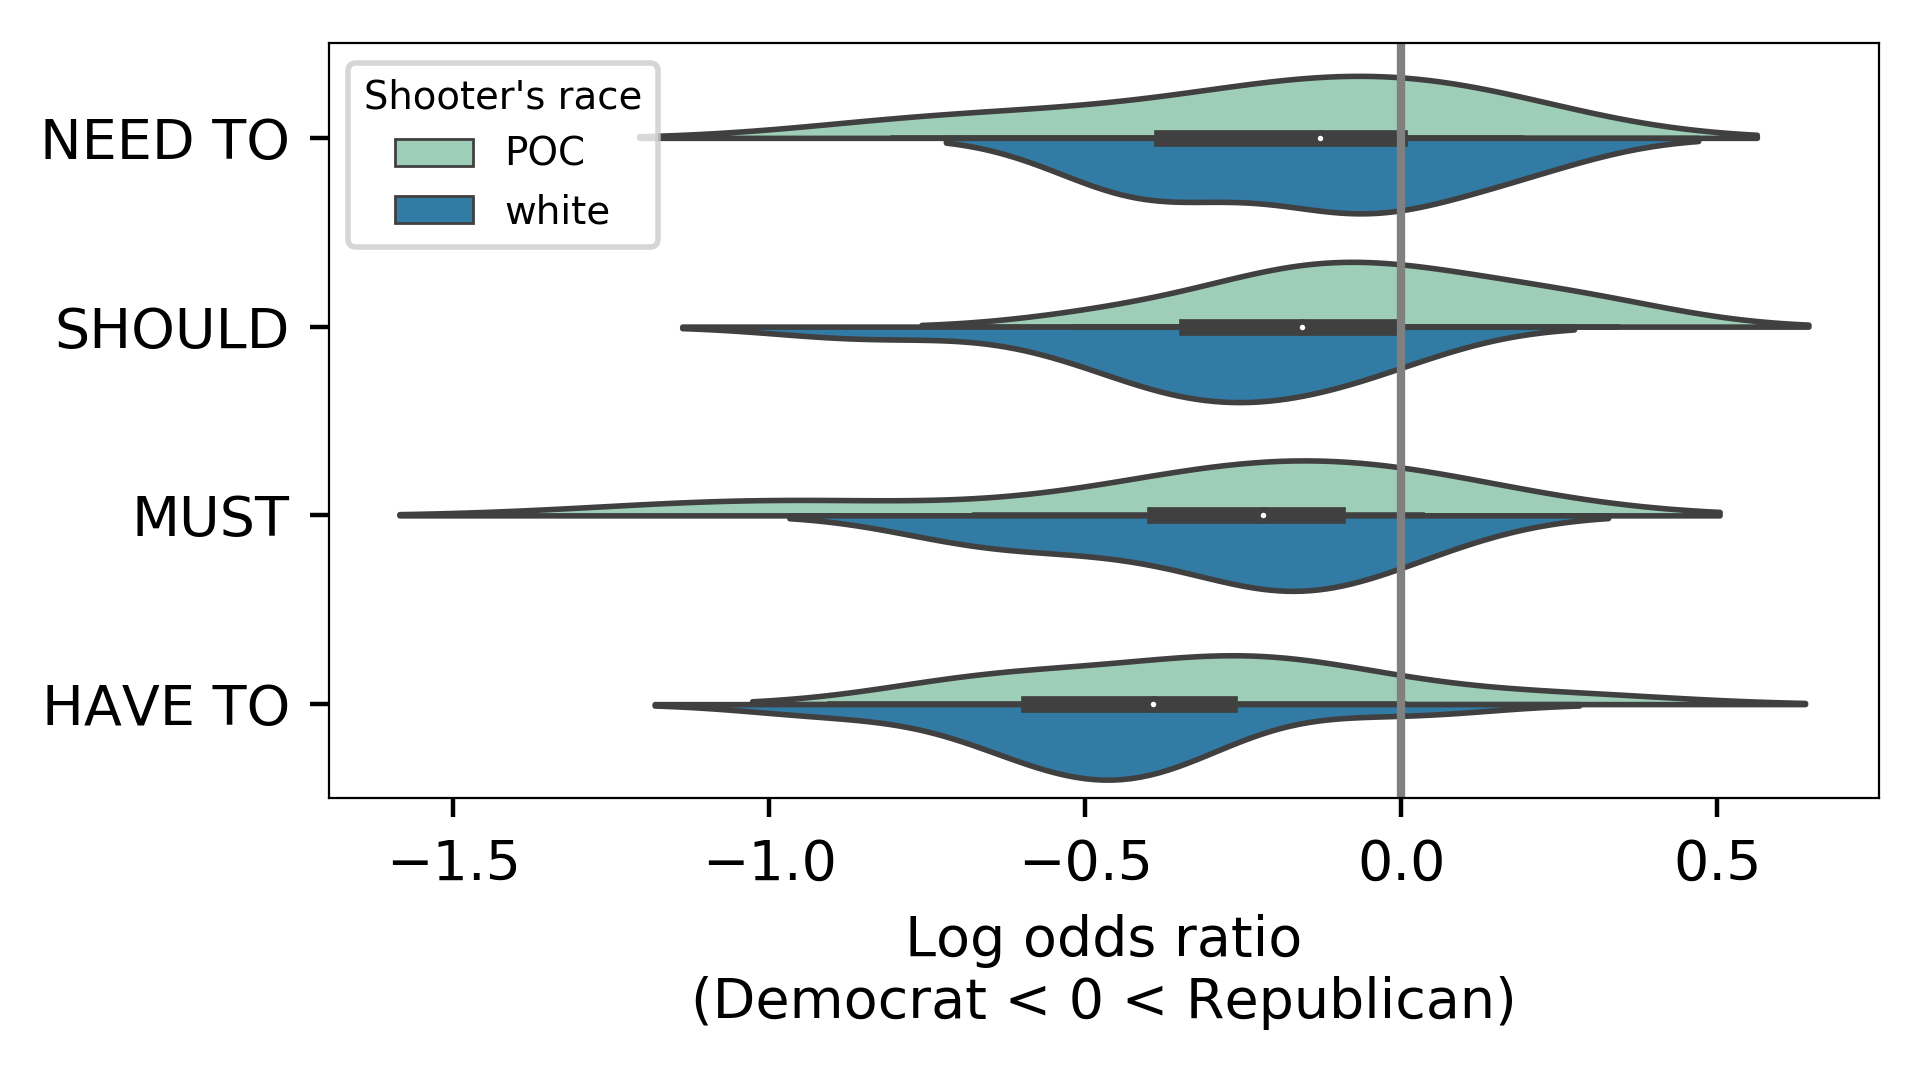

In [16]:
f = plt.figure(dpi=400, figsize=(5,2.5))
ax = sns.violinplot(data=df, x="log_odds",y="modal", hue='race', fliersize=1, linewidth=1, split=True, order=reversed(df.groupby('modal').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.axvline(x=0, color='grey')
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
legend = ax.legend(loc='upper left', title="Shooter's race", fontsize=7)
plt.setp(legend.get_title(),fontsize='x-small')

# distribution of modals across topics

In [17]:
modal_list = []
topic_list = []
value_list = []
event_list = []

def print_distr(event, name, s, total_props):
    print(name)
    b = np.bincount(s['topic'])
    vals = (b / np.sum(b)) / total_props
    #print(((b / np.sum(b)) / total_props))
    for i in range(NUM_CLUSTERS):
        topic_list.append(cluster_names[i])
        value_list.append(vals[i])
        modal_list.append(name)
        event_list.append(event)
        

for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',
                       usecols=['user_id', 'text'])
    data = get_cluster_assignments(event, data, 'relative')
    total_props = np.bincount(data['topic']) / np.sum(np.bincount(data['topic']))
    for k, v in regexes.items():
        s = data[data['text'].str.contains(v, case=False)]
        print_distr(event, k, s, total_props)

chattanooga
MUST
SHOULD
NEED TO
HAVE TO
roseburg
MUST
SHOULD
NEED TO
HAVE TO
colorado_springs
MUST
SHOULD
NEED TO
HAVE TO
san_bernardino
MUST
SHOULD
NEED TO
HAVE TO
kalamazoo
MUST
SHOULD
NEED TO
HAVE TO
orlando
MUST
SHOULD
NEED TO
HAVE TO
dallas
MUST
SHOULD
NEED TO
HAVE TO
baton_rouge
MUST
SHOULD
NEED TO
HAVE TO
burlington
MUST
SHOULD
NEED TO
HAVE TO
fort_lauderdale
MUST
SHOULD
NEED TO
HAVE TO
fresno
MUST
SHOULD
NEED TO
HAVE TO
san_francisco
MUST
SHOULD
NEED TO
HAVE TO
vegas
MUST
SHOULD
NEED TO
HAVE TO
thornton
MUST
SHOULD
NEED TO
HAVE TO
sutherland_springs
MUST
SHOULD
NEED TO
HAVE TO
parkland
MUST
SHOULD
NEED TO
HAVE TO
nashville
MUST
SHOULD
NEED TO
HAVE TO
santa_fe
MUST
SHOULD
NEED TO
HAVE TO
annapolis
MUST
SHOULD
NEED TO
HAVE TO
pittsburgh
MUST
SHOULD
NEED TO
HAVE TO
thousand_oaks
MUST
SHOULD
NEED TO
HAVE TO


In [18]:
df = pd.DataFrame.from_dict({'modal':modal_list, 'proportion':value_list, 'topic':topic_list, 'event':event_list})

In [19]:
df.to_csv(OUTPUT_DIR + 'modal_distributions.csv')

# modality & tense

In [21]:
shouldve_odds = []
prop_shouldve = []
should_odds = []
race = []


for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR +event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'remove', 'isRT'])
    # data['text'].str.contains(r'http|\.com|www', case=False)
    data = filter_retweets(data)
    # get partisan tweets
    data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
    dem, rep = split_party(data)
    search_shouldve = r"\bshould['‘’`]ve\b|\bshould( not)? have\b|\bshouldn['‘’`]t have\b"
    search_all_should = regexes['SHOULD']
    shouldve_odds.append(np.log(get_odds(rep, search_shouldve) / get_odds(dem, search_shouldve)))
    should_odds.append(np.log(get_odds(rep, search_all_should) / get_odds(dem, search_all_should)))
    prop = data['text'].str.contains(search_shouldve, case=False).sum() / data['text'].str.contains(search_all_should, case=False).sum()
    prop_shouldve.append(prop)
    race.append(shooter_race[event])

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


In [22]:
events

['chattanooga',
 'roseburg',
 'colorado_springs',
 'san_bernardino',
 'kalamazoo',
 'orlando',
 'dallas',
 'baton_rouge',
 'burlington',
 'fort_lauderdale',
 'fresno',
 'san_francisco',
 'vegas',
 'thornton',
 'sutherland_springs',
 'parkland',
 'nashville',
 'santa_fe',
 'annapolis',
 'pittsburgh',
 'thousand_oaks']

In [23]:
df = pd.DataFrame.from_dict({'shouldve_prop':prop_shouldve, 'should_odds':should_odds, 'shouldve_odds':shouldve_odds, 'race':race})

In [24]:
np.mean(shouldve_odds)

-0.21587544233441927

In [25]:
np.std(prop_shouldve)

0.052944556710957644

In [26]:
np.mean(prop_shouldve)

0.1559612896053431

In [27]:
ttest_1samp(shouldve_odds, 0)

Ttest_1sampResult(statistic=-2.0883401574328095, pvalue=0.049763460044135156)

In [28]:
ttest_ind(shouldve_odds, should_odds)

Ttest_indResult(statistic=-0.3044664887011898, pvalue=0.7623509719875924)

In [29]:
ttest_ind(shouldve_odds[:9], shouldve_odds[9:])

Ttest_indResult(statistic=-1.115734667342028, pvalue=0.27844880005700556)

In [30]:
print(np.mean(np.array(df[df['race']=='white'].shouldve_odds)))
print(np.mean(np.array(df[df['race']=='POC'].shouldve_odds)))
print(ttest_ind(np.array(df[df['race']=='white'].shouldve_odds), np.array(df[df['race']=='POC'].shouldve_odds)))

-0.25162427601763
-0.1765517252828875
Ttest_indResult(statistic=-0.35469175838123573, pvalue=0.7267269963091383)


In [31]:
print(np.mean(np.array(df[df['race']=='white'].should_odds)))
print(np.mean(np.array(df[df['race']=='POC'].should_odds)))
print(ttest_ind(np.array(df[df['race']=='white'].should_odds), np.array(df[df['race']=='POC'].should_odds)))

-0.30436008739638987
-0.04267669615802142
Ttest_indResult(statistic=-2.5279065325489634, pvalue=0.02049621218814681)


# subjects & complements of modals

In [115]:
regexes_new = {
    'must': r"(\bmust(n['‘’`]?t?)?\b)|(\bmust['‘’`]?ve\b)",
    'should': r"(\bshould(n['‘’`]?t?)?\b)|(\bshould['‘’`]?ve\b)",
    'need to': r"\bneed to\b",
    'needs to': r"\bneeds to\b",
    'have to': r"\bhave to\b",
    'has to': r"\bhas to\b",
}
modal_replace = {
    'must': {'past': (r"must['‘’`]?ve", 'must have'), 'neg': (r"mustn['‘’`]?t", "must not")},
    'should': {'past': (r"should['‘’`]?ve", 'should have'), 'neg': (r"shouldn['‘’`]?t", "should not")},
}

In [122]:
def get_valid(l, isbef):
    append = []
    for t in l:
        if t in ['have', 've', 'not', 't', 'to', 'be', 'the', 'a', 'no', 'an']:
            append.append(t)
        elif len(append) > 0:
            if isbef:
                return t + ' ' + ' '.join(append)
            else:
                return ' '.join(append) + ' ' + t
        else:
            return t
    return ''

In [123]:
def log_odds(counts1, counts2, prior):
    # counts1 will be positive and counts2 will be negative
    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    n1 = sum(list(counts1.values()))
    n2 = sum(list(counts2.values()))
    nprior = sum(list(prior.values()))
    for word in prior.keys():
        if prior[word] == 0:
            delta[word] = 0
            continue
        l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
        l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
        sigmasquared[word] = 1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
        sigma[word] = math.sqrt(sigmasquared[word])
        delta[word] = (math.log(l1) - math.log(l2)) / sigma[word]
        #delta[word] = (math.log(l1) - math.log(l2))
    return delta

In [131]:
def get_contexts(tweets, m):
    before = []
    after = []
    trigrams = []
    twoword = False
    if len(m.split()) > 1:
        modal_first = m.split()[0]
        twoword = True
    else:
        modal_first = m
    tweets['text'] = tweets['text'].str.lower()
    if m in ['should', 'must']:
        tweets['text'] = tweets['text'].str.replace(modal_replace[m]['past'][0], modal_replace[m]['past'][1], regex=True)
        tweets['text'] = tweets['text'].str.replace(modal_replace[m]['neg'][0], modal_replace[m]['neg'][1], regex=True)
    tweets['text'] = tweets['text'].astype(str).apply(clean_text, args=(True, None, False))
    for words in tweets['text']:
        
        trigram = []
        if twoword:
            for i, w in enumerate(words[:-2]):
                if w == modal_first and words[i+1] == 'to':
                    trigram = [modal_first]
                    break
        else:
            for i, w in enumerate(words):
                if w == modal_first:
                    trigram = [modal_first]
                    break
        if len(trigram) == 0:
            continue
        bef = get_valid(reversed(words[:i]), isbef=True)
        aft = ''
        if i < len(words) -1:
            aft = get_valid(words[i+1:], isbef=False)
        trigram = [bef] + trigram + [aft]
        trigram = ' '.join(trigram)
        if bef != '':
            before.append(bef)
        if aft != '':
            after.append(aft)
        trigrams.append(trigram)
    return Counter(before), Counter(after), Counter(trigrams)

In [132]:
rep_modal_bef = {m:[] for m in regexes_new}
dem_modal_bef = {m:[] for m in regexes_new}
rep_modal_aft = {m:[] for m in regexes_new}
dem_modal_aft = {m:[] for m in regexes_new}
rep_modal_tri = {m:[] for m in regexes_new}
dem_modal_tri = {m:[] for m in regexes_new}

def add_vals(contains, m):
    dem, rep = split_party(contains)
    print(len(dem), len(rep))
    # Dem
    bef, aft, tri = get_contexts(dem, m)
    dem_modal_bef[m].append(bef)
    dem_modal_aft[m].append(aft)
    dem_modal_tri[m].append(tri)
    # Rep
    bef, aft, tri = get_contexts(rep, m)
    rep_modal_bef[m].append(bef)
    rep_modal_aft[m].append(aft)
    rep_modal_tri[m].append(tri)
    
for event in events:
    print(event)
    data = pd.read_csv(TWEET_DIR+event+'/'+event+'.csv', sep='\t', lineterminator='\n', usecols=['text', 'rep_follows', 'dem_follows', 'isRT', 'remove'])
    data = filter_retweets(data)
    #data =  data[~data['text'].str.contains(r'http|\.com|www', case=False)]  # add to filter URLs
    for k, v in regexes_new.items():
        contains = data[data['text'].str.contains(v, case=False)]
        print(k)
        add_vals(contains, k)

chattanooga
must
54 123
should
106 372
need to
41 102
needs to
10 47
have to
39 72
has to
12 26
roseburg
must
93 24
should
125 85
need to
55 26
needs to
44 16
have to
57 19
has to
25 13
colorado_springs
must
223 92
should
744 254
need to
190 58
needs to
69 30
have to
162 60
has to
44 12
san_bernardino
must
184 153
should
307 374
need to
171 148
needs to
81 51
have to
144 94
has to
58 44
kalamazoo
must
34 16
should
105 42
need to
38 24
needs to
11 8
have to
50 11
has to
14 3
orlando
must
3962 3731
should
8336 7013
need to
3637 2806
needs to
1844 1152
have to
2667 1262
has to
882 464
dallas
must
701 661
should
1330 1663
need to
747 734
needs to
304 403
have to
497 429
has to
218 202
baton_rouge
must
185 211
should
214 254
need to
158 227
needs to
63 140
have to
115 142
has to
96 119
burlington
must
7 13
should
14 28
need to
12 10
needs to
9 6
have to
4 6
has to
1 3
fort_lauderdale
must
19 10
should
26 22
need to
14 18
needs to
8 7
have to
10 7
has to
4 7
fresno
must
14 38
should
15 69
ne

In [145]:
def get_most_partisan(dem_vals, rep_vals):
    most_rep = {m:[] for m in regexes_new}
    most_dem = {m:[] for m in regexes_new}
    for m in regexes_new:
        for i, (d, r) in enumerate(zip(dem_vals[m], rep_vals[m])):
            if len(d) == 0 or len(r) == 0:
                continue
            odds = log_odds(d, r, d+r)
            most_rep[m].extend([k for k, v in odds.items() if v <= -.5])
            most_dem[m].extend([k for k, v in odds.items() if v >= .5])
    for m in most_rep:
        most_rep[m] = Counter(most_rep[m]).most_common()
    for m in most_dem:
        most_dem[m] = Counter(most_dem[m]).most_common()
    return most_rep, most_dem

In [146]:
most_rep_bef, most_dem_bef = get_most_partisan(dem_modal_bef, rep_modal_bef)
most_rep_aft, most_dem_aft = get_most_partisan(dem_modal_aft, rep_modal_aft)
most_rep_tri, most_dem_tri= get_most_partisan(dem_modal_tri, rep_modal_tri)

In [147]:
def print_top(dem, rep):
    for m,  v in dem.items():
        print('\\begin{center}\\textbf{' + m.upper() + '}\\end{center}')
        toprint_dem = ''
        for k, count in v:
            if count > 2:
                toprint_dem += "%s (%d), " % (k, count)
        print('\\noindent\\emph{Democrat}\\\\' + toprint_dem[:-2].replace('#','\\#') + '\\\\')
        toprint_rep = ''
        for k, count in rep[m]:
            if count > 3:
                toprint_rep += "%s (%d), " % (k, count)
        print('\\noindent\\emph{Republican}\\\\' + toprint_rep[:-2].replace('#','\\#') + '\\\\')
    

In [148]:
print_top(most_dem_tri, most_rep_tri)

\begin{center}\textbf{MUST}\end{center}
\noindent\emph{Democrat}\\we must do (14), this must stop (8), we must end (7), something must be done (7), we must act (7), long must we (7), congress must act (7), we must stand (6), we must stop (6), he must be white (6), we must address (6), violence must end (6), violence must stop (6), lives must be lost (6), killing must stop (6), we must make (6), times must this (5), it must stop (5), we must all (5), people must die (5), many must die (5), we must keep (5), and must do (5), we must pass (5), we must continue (5), times must we (5), this must end (5), we must take (5), we must honor (5), shooter must be white (5), shooter must have been (4), insanity must stop (4), we must treat (4), we must remember (4), shootings must stop (4), is a must  (4), shootings must end (4), change must happen (4), congress must take (4), this must change (4), we must get (4), action must be taken (4), control must happen (4), we must push (4), we must find (4

In [149]:
print_top(most_dem_bef, most_rep_bef)

\begin{center}\textbf{MUST}\end{center}
\noindent\emph{Democrat}\\we (14), violence (10), this (8), long (8), congress (8), and (7), madness (7), something (6), shootings (6), laws (6), more (6), shooter (5), insanity (5), i (5), lives (5), times (5), many (5), prayers (5), nra (5), weapons (5), \#nra (5), rifles (5), people (4), government (4), is a (4), nation (4), action (4), guns (4), ppl (4), victims (4), love (4), things (4), owners (4), \#republicans (4), \#gunviolence (4), are a (4), there (4), muslims (3), he (3), leaders (3), it (3), checks (3), somebody (3), killing (3), senate (3), family (3), they (3), change (3), epidemic (3), innocents (3), tragedies (3), all (3), killings (3), politicians (3), gop (3), \#gunsense (3), \#gunreform (3), blood (3), men (3), how (3), reform (3), officials (3), \#gop (3), back (3), these (3), god (3), money (3), children (3), rights (3), terrorism (3), candidates (3), issue (3), control (3), country (3)\\
\noindent\emph{Republican}\\shooting

In [150]:
print_top(most_dem_aft, most_rep_aft)

\begin{center}\textbf{MUST}\end{center}
\noindent\emph{Democrat}\\do (14), end (11), stop (10), all (8), die (7), act (7), be white (7), change (7), this (6), be done (6), ask (6), be taken (6), be lost (6), pass (6), continue (6), stand (6), address (6), also (5), remember (5), take (5), find (5), suffer (5), we (5), honor (5), treat (4), be so (4), be hard (4), ensure (4), be stopped (4), happen (4), fear (4), have gun (4), finally (4), come (4), push (4), keep (4), live (4), work (4), confront (4), combat (4), make (4), hold (4), rise (4), include (4), enact (4), be a white (4), perish (3), say (3), condemn (3), mean (3), reclaim (3), be passed (3), be brown (3), get (3), join (3), follow (3), understand (3), \#stopgunviolence (3), attack (3), begin (3), now (3), fight (3), help (3), read (3), fucking (3), prevail (3), be broken (3), be feeling (3), regulate (3), try (3), be enacted (3), be all (3), have change (3), be better (3), be careful (3), examine (3), fix (3), admit (3), be 